In [31]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import rotate, rescale

from myAE import Manager

import torch
from torch import nn
import torch.nn.functional as F

In [32]:
x = np.zeros([5000, 1, 28, 28], dtype=np.float32)

img = np.zeros([28, 28], dtype=np.float32)
img[5:22, 12:16] = 1

for idx in range(5000):
    img_r = rescale(img, np.random.uniform(0.7, 1.3), anti_aliasing=True)
    while img_r.shape[0] % 2:
        img_r = rescale(img, np.random.uniform(0.7, 1.3), anti_aliasing=True)

    if img_r.shape[0] > 28:
        l, r = img_r.shape[0] // 2 - 15, img_r.shape[0] // 2 + 13
        img_r = img_r[l:r, l:r]
    elif img_r.shape[0] < 28:
        l, r = (28 - img_r.shape[0]) // 2, 28 - (28 - img_r.shape[0]) // 2
        tmp = np.zeros([28, 28])
        tmp[l:r, l:r] = img_r
        img_r = tmp

    img_r = rotate(img_r, np.random.uniform(-40, 40))
    x[idx, 0] = img_r

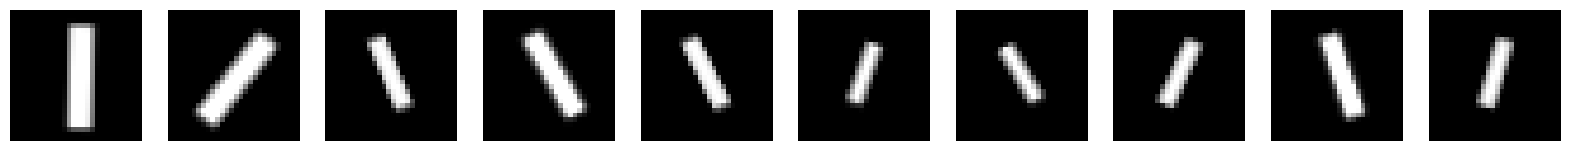

In [33]:
_, axs = plt.subplots(1, 10, figsize=[20, 5])
for img, ax in zip(x, axs):
    ax.imshow(img.reshape([28, 28]), cmap='gray')
    ax.axis('off')

In [4]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager = Manager()
manager.set_data(x, np.zeros(len(x), dtype=int))
manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=50)

Now, it is working on cuda:0.


100%|██████████| 50/50 [00:19<00:00,  2.63it/s]


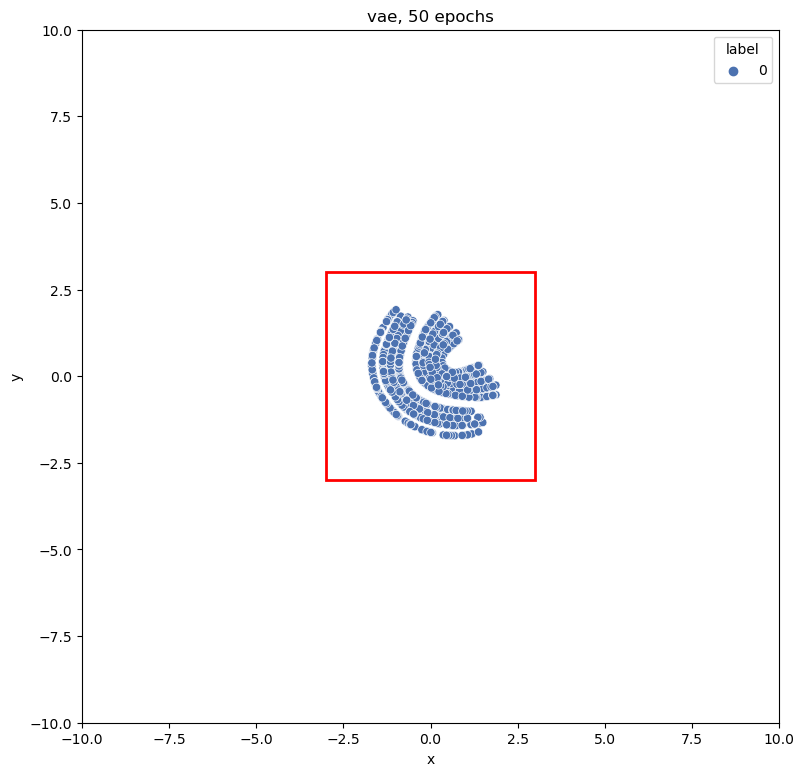

In [5]:
def encode(model, x, y):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    return [mu]

manager.show_latent_space('vae, 50 epochs', encode)

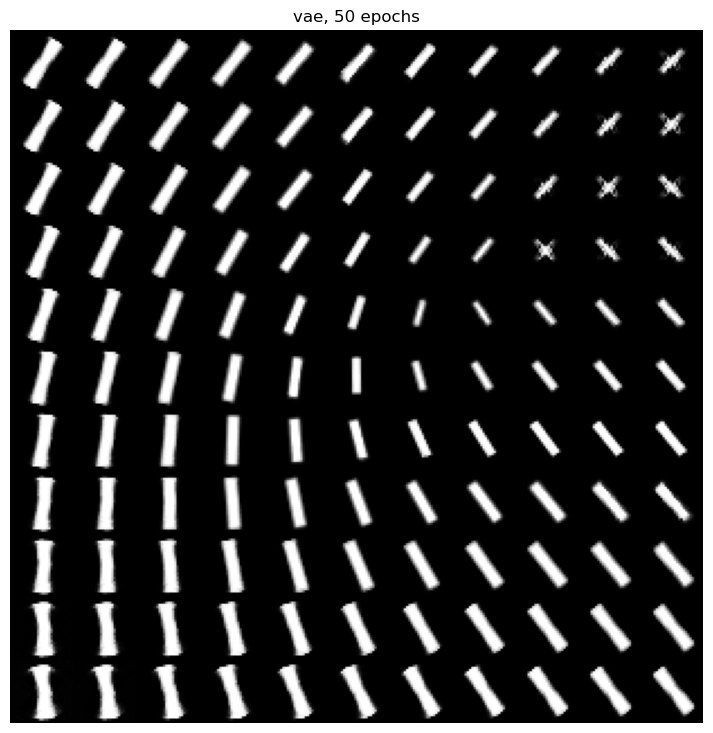

In [6]:
manager.plot_generated_images('vae, 50 epochs')

### third factor

In [70]:
x_3rd = np.zeros([50, 1, 28, 28], dtype=np.float32)

import random

for idx in range(len(x_3rd)):

    img = np.zeros([28, 28], dtype=np.float32)
    img[5:22, 12:16] = 1

    mark = random.randint(5, 6)

    id_x, id_y = 11, 6
    for m in range(mark):
        while id_x < 12:
            img[id_y, id_x] = 1
            id_x += 1
        id_x = 11 - m
        id_y += 1

    img_3rd = rescale(img, np.random.uniform(0.7, 1.3), anti_aliasing=True)
    while img_3rd.shape[0] % 2:
        img_3rd = rescale(img, np.random.uniform(0.7, 1.3), anti_aliasing=True)

    if img_3rd.shape[0] > 28:
        l, r = img_3rd.shape[0] // 2 - 15, img_3rd.shape[0] // 2 + 13
        img_3rd = img_3rd[l:r, l:r]
    elif img_3rd.shape[0] < 28:
        l, r = (28 - img_3rd.shape[0]) // 2, 28 - (28 - img_3rd.shape[0]) // 2
        tmp = np.zeros([28, 28])
        tmp[l:r, l:r] = img_3rd
        img_3rd = tmp

    img_3rd = rotate(img_3rd, np.random.uniform(-40, 40))
    x_3rd[idx, 0] = img_3rd

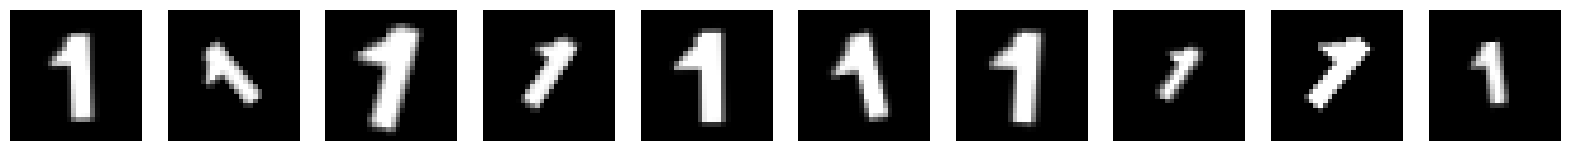

In [71]:
_, axs = plt.subplots(1, 10, figsize=[20, 5])
for img, ax in zip(x_3rd, axs):
    ax.imshow(img.reshape([28, 28]), cmap='gray')
    ax.axis('off')

In [72]:
x_x3 = np.concatenate([x, x_3rd], axis=0)
x_x3.shape

(5050, 1, 28, 28)

In [73]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager = Manager()
manager.set_data(x_x3, np.zeros(len(x_x3), dtype=int))
manager.set_default_model(4, 2)

hist = manager.train(calc_loss, epochs=50)

Now, it is working on cuda:0.


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


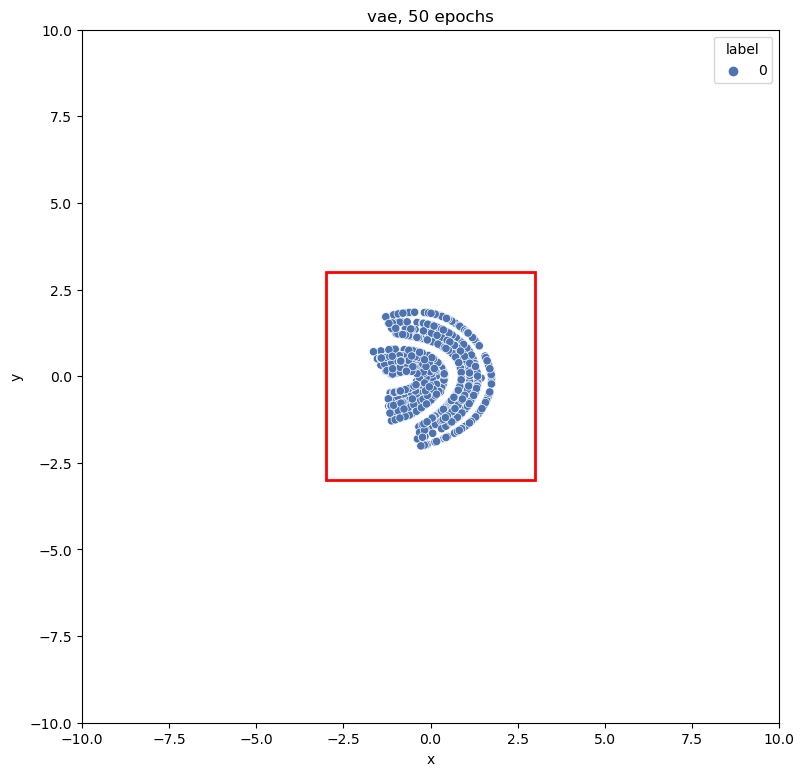

In [74]:
def encode(model, x, y):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    return [mu]

manager.show_latent_space('vae, 50 epochs', encode)

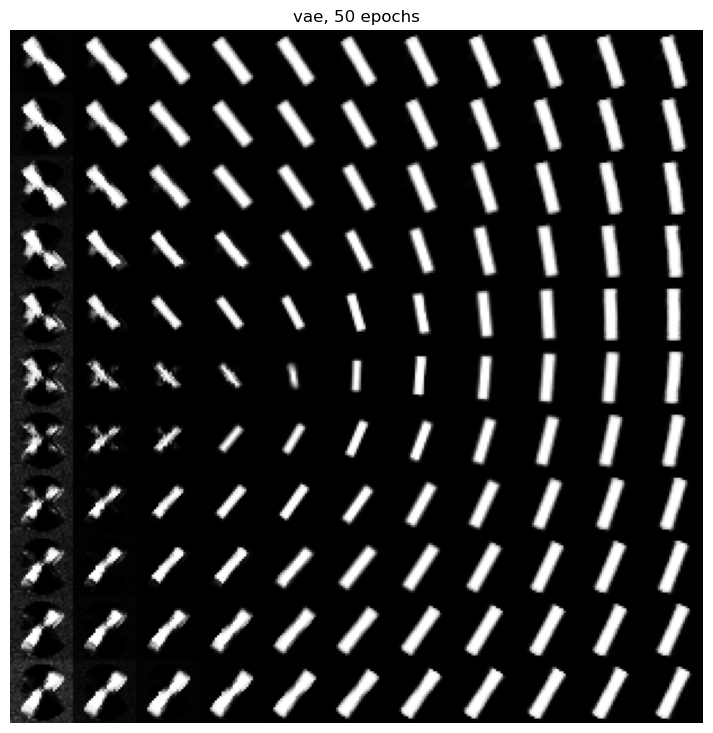

In [75]:
manager.plot_generated_images('vae, 50 epochs')

In [63]:
tmp = torch.randn(1000) * torch.rand(1000) + torch.rand(1000)
((tmp - tmp.mean()).abs() > tmp.std() * 2).sum()

tensor(57)

In [90]:
def run_one(ratio=0.01, epochs=100):
    x_3rd = np.zeros([int(5000 * ratio), 1, 28, 28], dtype=np.float32)

    for idx in range(len(x_3rd)):

        img = np.zeros([28, 28], dtype=np.float32)
        img[5:22, 12:16] = 1

        mark = random.randint(5, 6)

        id_x, id_y = 11, 6
        for m in range(mark):
            while id_x < 12:
                img[id_y, id_x] = 1
                id_x += 1
            id_x = 11 - m
            id_y += 1

        img_3rd = rescale(img, np.random.uniform(0.7, 1.3), anti_aliasing=True)
        while img_3rd.shape[0] % 2:
            img_3rd = rescale(img, np.random.uniform(0.7, 1.3), anti_aliasing=True)

        if img_3rd.shape[0] > 28:
            l, r = img_3rd.shape[0] // 2 - 15, img_3rd.shape[0] // 2 + 13
            img_3rd = img_3rd[l:r, l:r]
        elif img_3rd.shape[0] < 28:
            l, r = (28 - img_3rd.shape[0]) // 2, 28 - (28 - img_3rd.shape[0]) // 2
            tmp = np.zeros([28, 28])
            tmp[l:r, l:r] = img_3rd
            img_3rd = tmp

        img_3rd = rotate(img_3rd, np.random.uniform(-40, 40))
        x_3rd[idx, 0] = img_3rd
    
    x_x3 = np.concatenate([x, x_3rd], axis=0)

    manager = Manager()
    manager.set_data(x_x3, np.zeros(len(x_x3), dtype=int))
    manager.set_default_model(4, 2)

    hist = manager.train(calc_loss, epochs=epochs)
    return manager

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


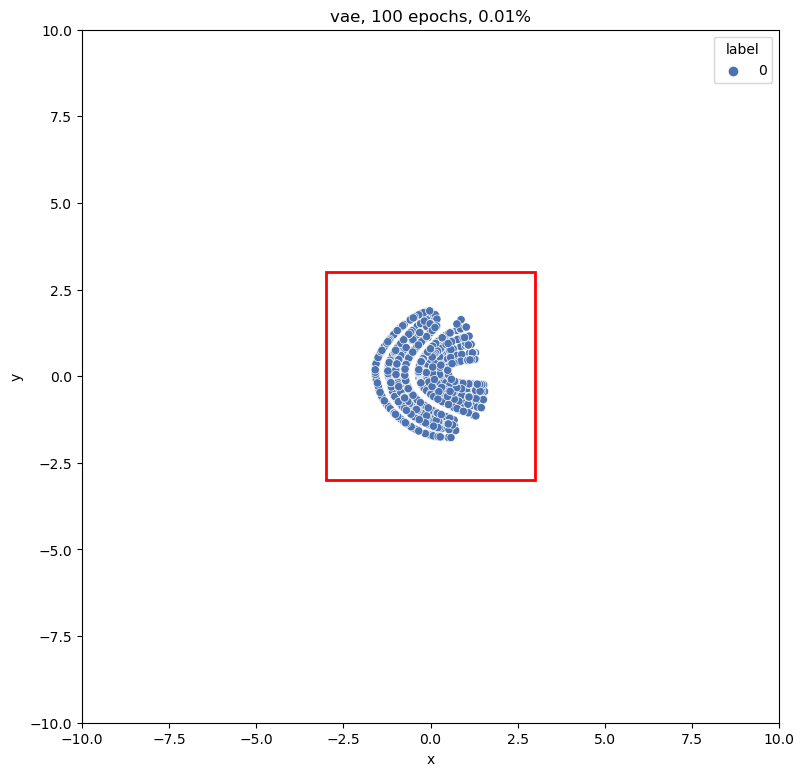

In [78]:
ratio = 0.01
m2 = run_one(ratio)
m2.show_latent_space(f'vae, 100 epochs, {ratio}%', encode)

Now, it is working on cuda:0.


100%|██████████| 1000/1000 [05:42<00:00,  2.92it/s]


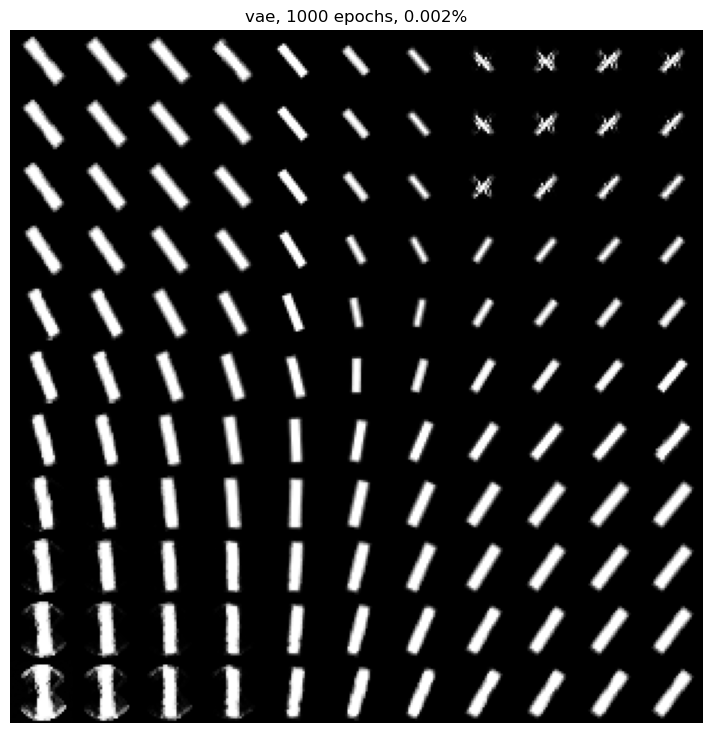

In [91]:
ratio = 0.002
m2 = run_one(ratio, 1000)
m2.plot_generated_images(f'vae, 1000 epochs, {ratio}%')

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:34<00:00,  2.89it/s]


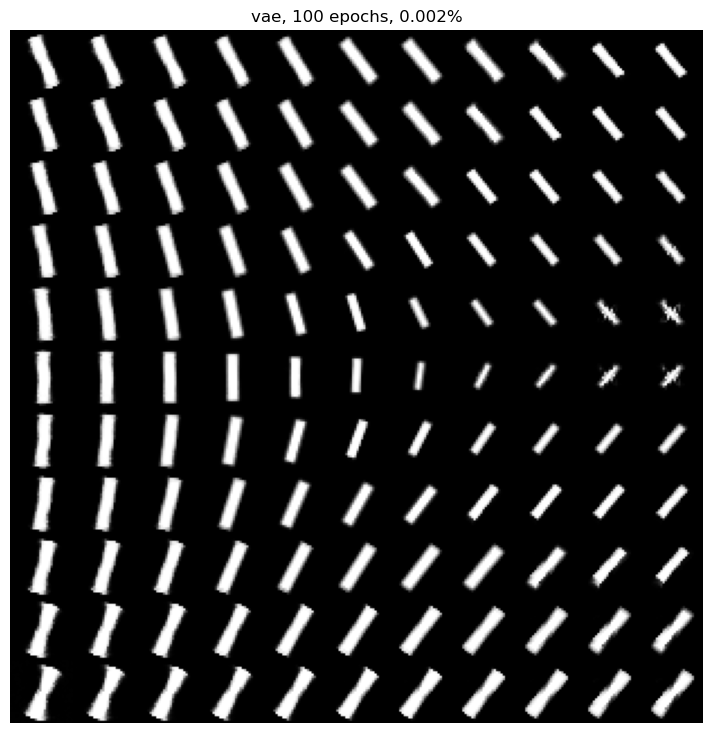

In [89]:
ratio = 0.002
m2 = run_one(ratio)
m2.plot_generated_images(f'vae, 100 epochs, {ratio}%')

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:35<00:00,  2.83it/s]


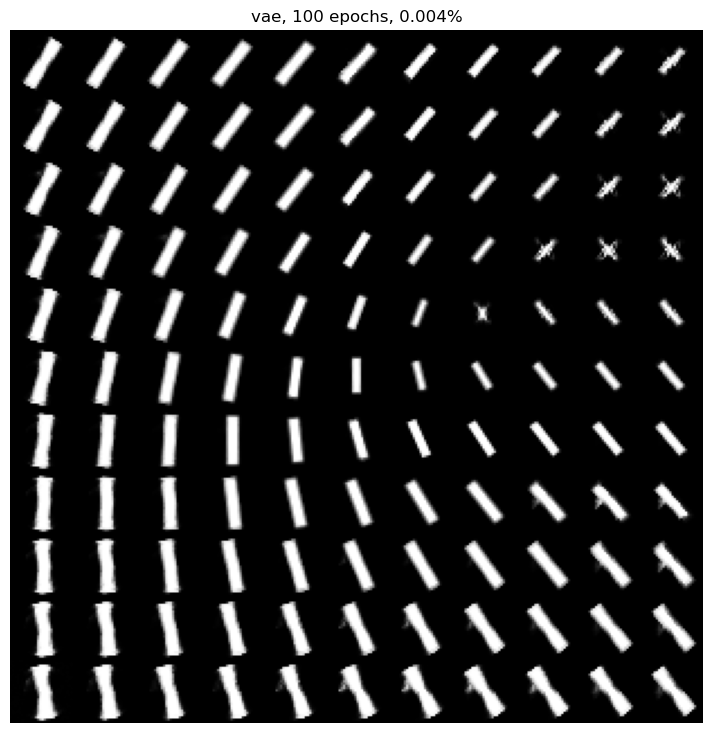

In [87]:
ratio = 0.004
m2 = run_one(ratio)
m2.plot_generated_images(f'vae, 100 epochs, {ratio}%')

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


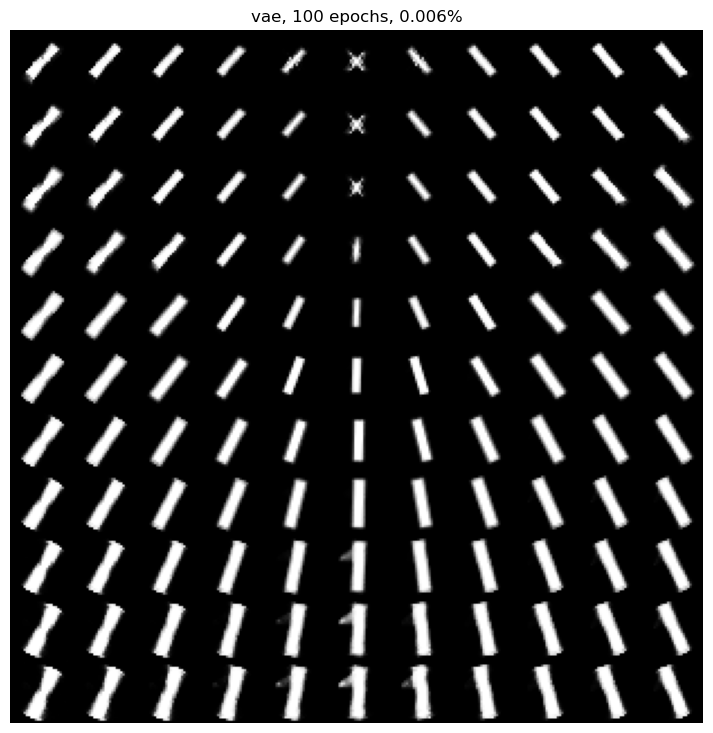

In [86]:
ratio = 0.006
m2 = run_one(ratio)
m2.plot_generated_images(f'vae, 100 epochs, {ratio}%')

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:34<00:00,  2.86it/s]


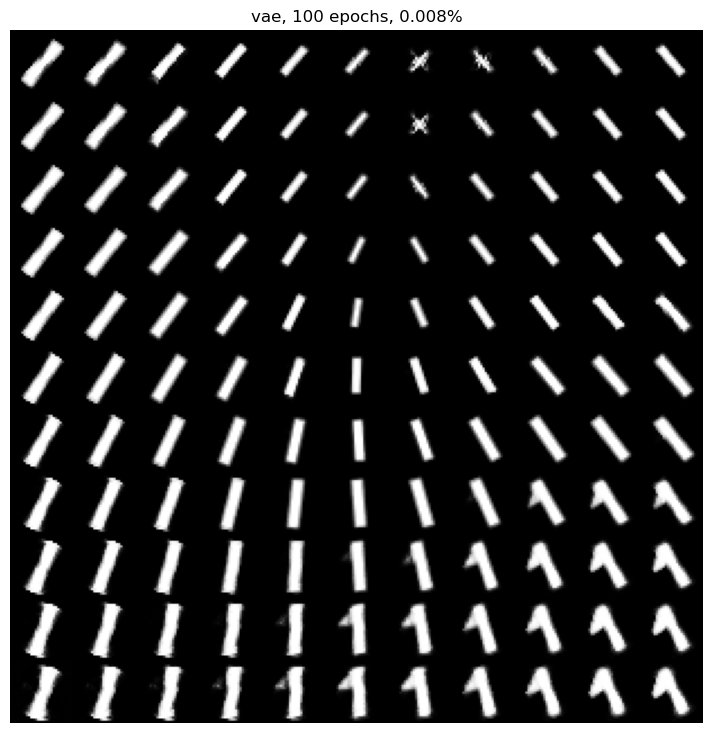

In [85]:
ratio = 0.008
m2 = run_one(ratio)
m2.plot_generated_images(f'vae, 100 epochs, {ratio}%')

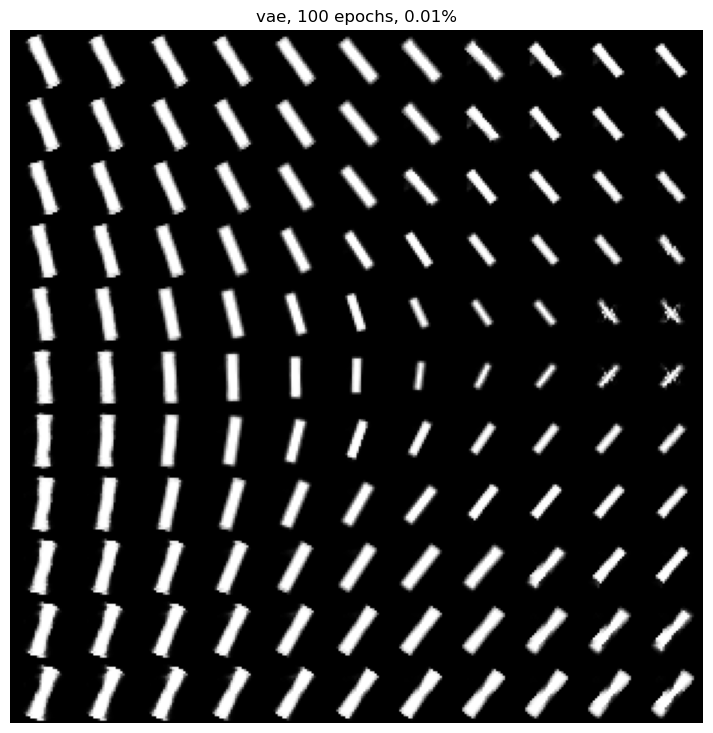

In [79]:
ratio = 0.01
m2 = run_one(ratio)
m2.plot_generated_images(f'vae, 100 epochs, {ratio}%')

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:34<00:00,  2.86it/s]


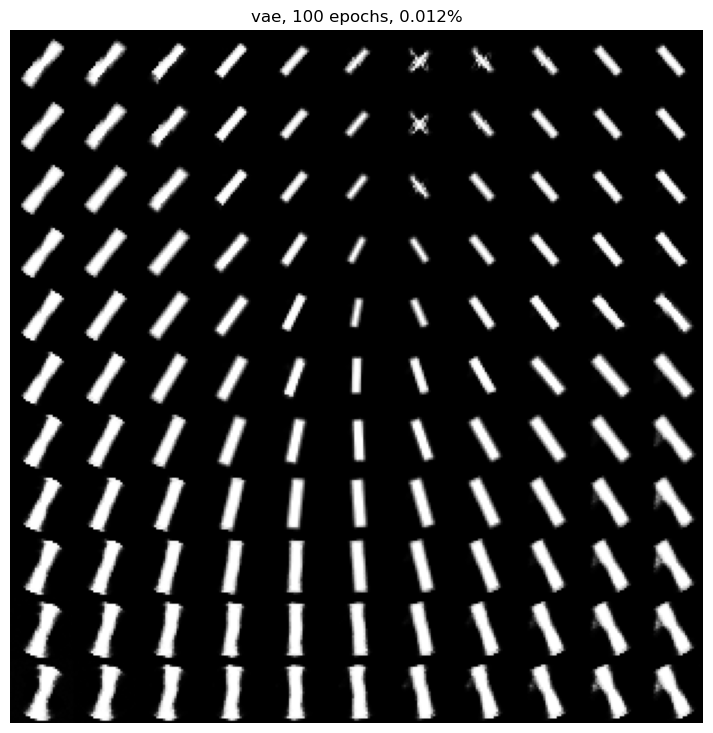

In [81]:
ratio = 0.012
m2 = run_one(ratio)
m2.plot_generated_images(f'vae, 100 epochs, {ratio}%')

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:34<00:00,  2.86it/s]


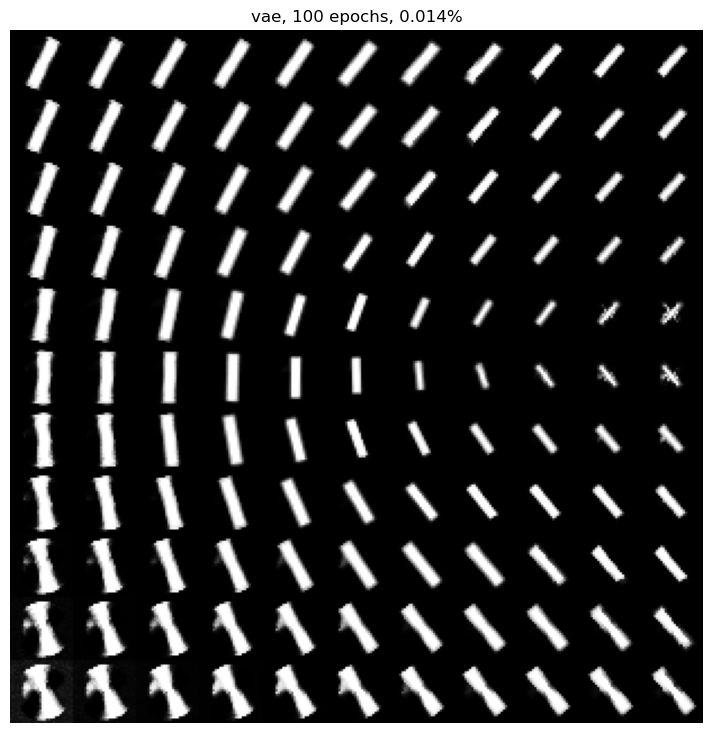

In [82]:
ratio = 0.014
m2 = run_one(ratio)
m2.plot_generated_images(f'vae, 100 epochs, {ratio}%')

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


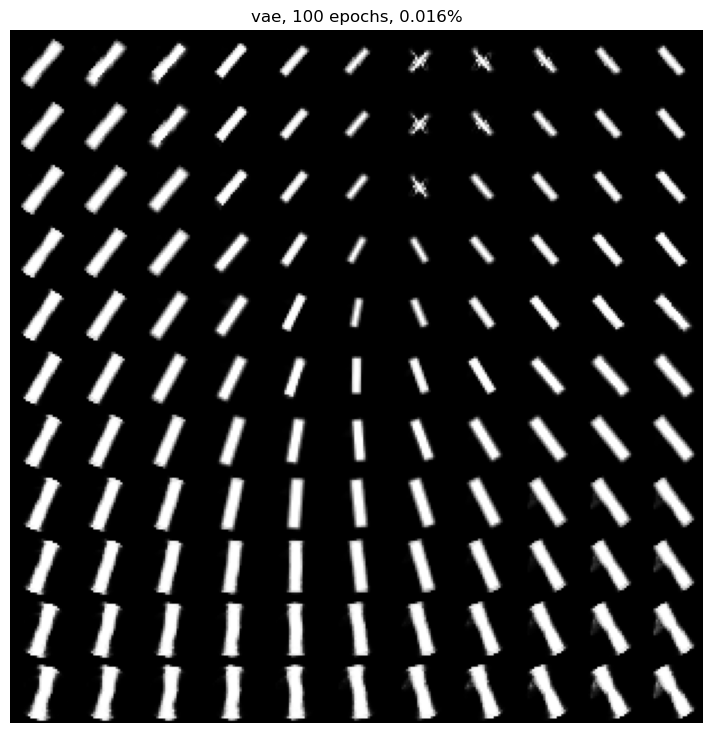

In [83]:
ratio = 0.016
m2 = run_one(ratio)
m2.plot_generated_images(f'vae, 100 epochs, {ratio}%')

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


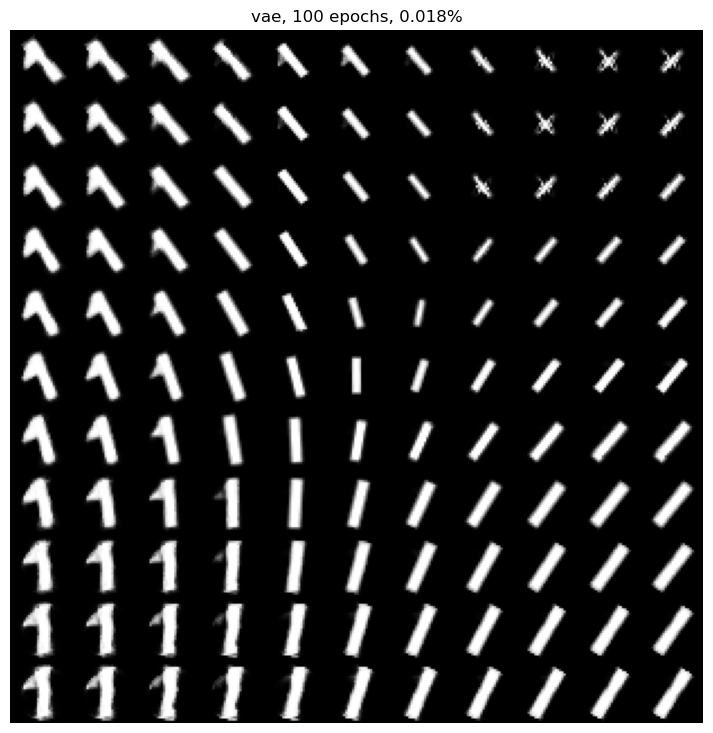

In [84]:
ratio = 0.018
m2 = run_one(ratio)
m2.plot_generated_images(f'vae, 100 epochs, {ratio}%')

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:35<00:00,  2.83it/s]


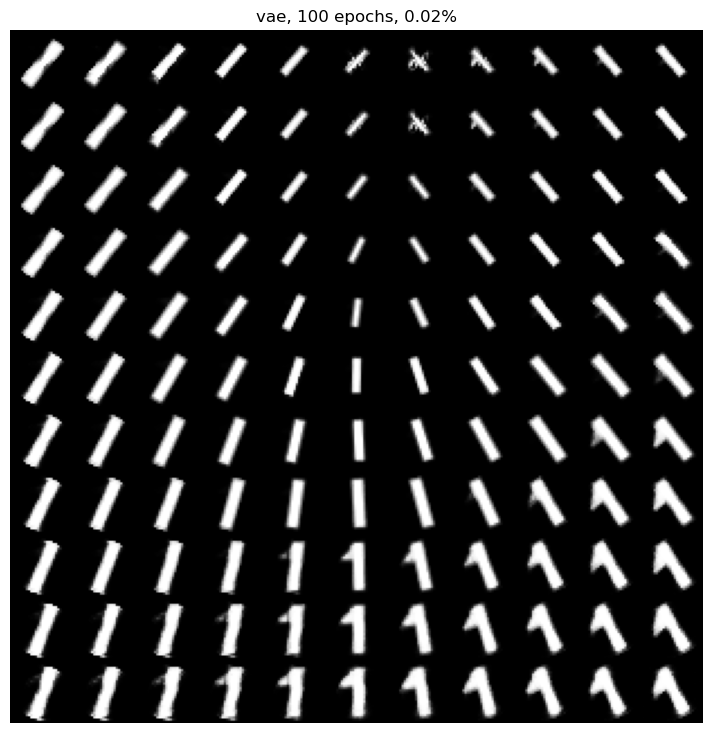

In [80]:
ratio = 0.02
m2 = run_one(ratio)
m2.plot_generated_images(f'vae, 100 epochs, {ratio}%')

In [133]:
def run_one_2(ratio=0.01, epochs=100):
    x_3rd = np.zeros([int(5000 * ratio), 1, 28, 28], dtype=np.float32)

    for idx in range(len(x_3rd)):

        img = np.zeros([28, 28], dtype=np.float32)
        img[5:22, 12:16] = 1

        mark = random.randint(5, 6)

        id_x, id_y = 11, 6
        for m in range(mark):
            while id_x < 12:
                img[id_y, id_x] = 1
                id_x += 1
            id_x = 11 - m
            id_y += 1

        img_3rd = rescale(img, np.random.uniform(0.7, 1.3), anti_aliasing=True)
        while img_3rd.shape[0] % 2:
            img_3rd = rescale(img, np.random.uniform(0.7, 1.3), anti_aliasing=True)

        if img_3rd.shape[0] > 28:
            l, r = img_3rd.shape[0] // 2 - 15, img_3rd.shape[0] // 2 + 13
            img_3rd = img_3rd[l:r, l:r]
        elif img_3rd.shape[0] < 28:
            l, r = (28 - img_3rd.shape[0]) // 2, 28 - (28 - img_3rd.shape[0]) // 2
            tmp = np.zeros([28, 28])
            tmp[l:r, l:r] = img_3rd
            img_3rd = tmp

        img_3rd = rotate(img_3rd, np.random.uniform(-40, 40))
        x_3rd[idx, 0] = img_3rd
    
    x_x3 = np.concatenate([x, x_3rd], axis=0)

    manager = Manager()
    manager.set_data(x_x3, np.zeros(len(x_x3), dtype=int))
    manager.set_default_model(4, 2)

    hist = manager.train(calc_loss, epochs=epochs)

    device = 'cpu'
    manager.model.to(device)

    with torch.no_grad():
        h = manager.model.get_submodule("encoder")(torch.from_numpy(x_3rd[:10]))
        mu = h[:, :2]
        pred = manager.model.get_submodule("decoder")(mu)
        

    _, axs = plt.subplots(1, 10, figsize=[20, 2])
    for img, ax in zip(pred, axs):
        ax.imshow(img.view([28, 28]), cmap='gray')
        ax.axis('off')
    plt.suptitle(f'vae, {epochs} epochs, {ratio}%')

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


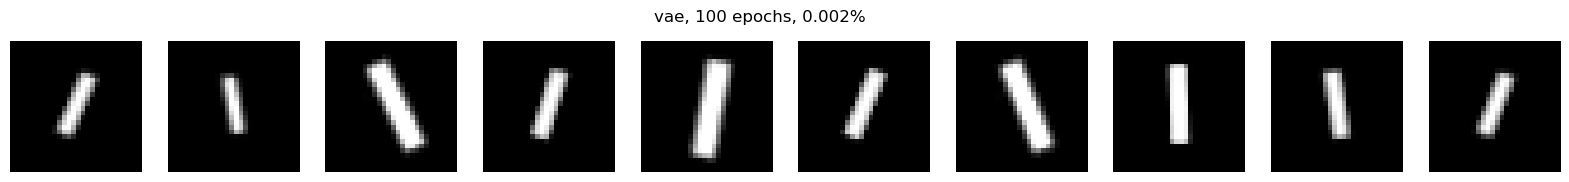

In [134]:
run_one_2(0.002, 100)

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


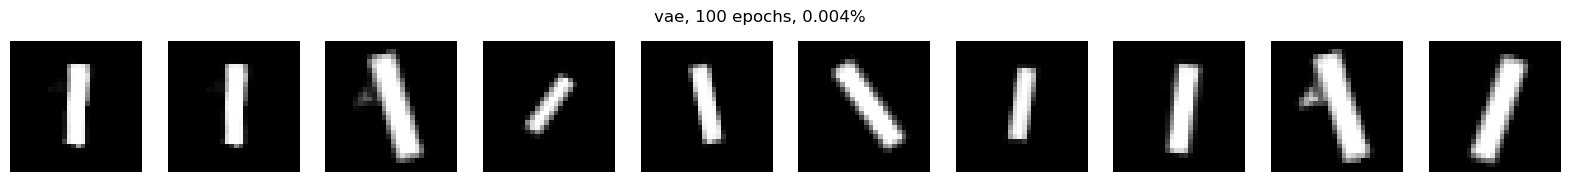

In [135]:
run_one_2(0.004, 100)

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:34<00:00,  2.92it/s]


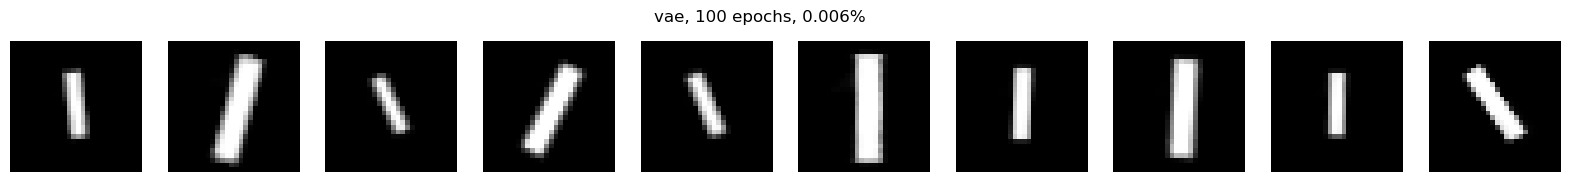

In [136]:
run_one_2(0.006, 100)

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:32<00:00,  3.05it/s]


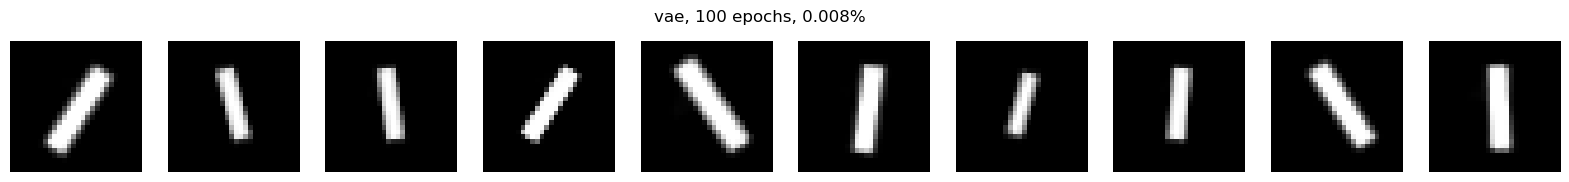

In [137]:
run_one_2(0.008, 100)

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:33<00:00,  2.95it/s]


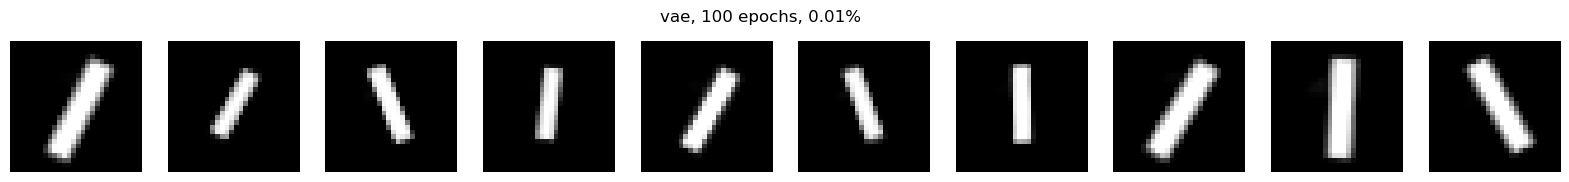

In [138]:
run_one_2(0.01, 100)

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


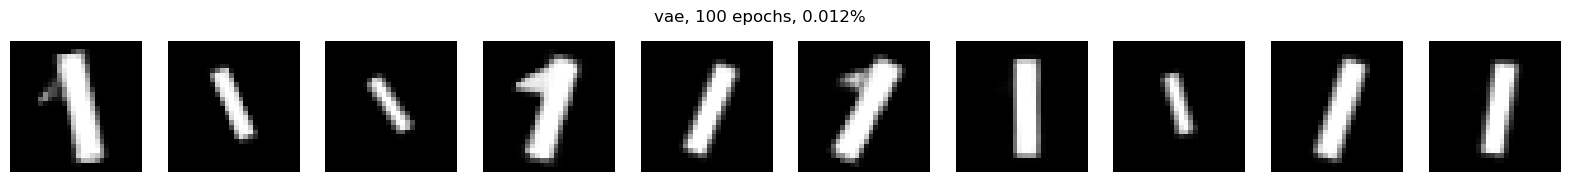

In [139]:
run_one_2(0.012, 100)

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:34<00:00,  2.88it/s]


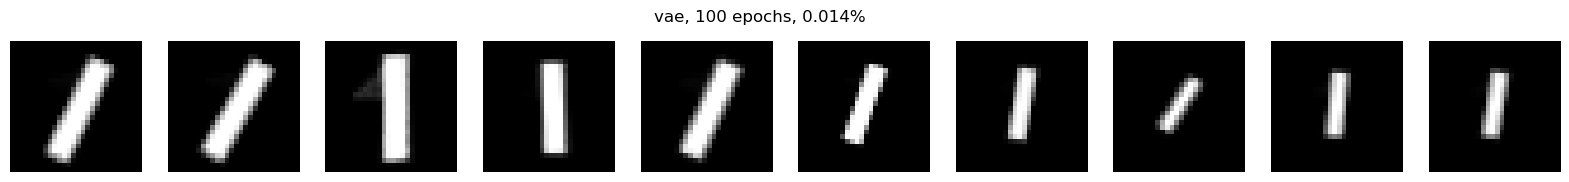

In [140]:
run_one_2(0.014, 100)

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


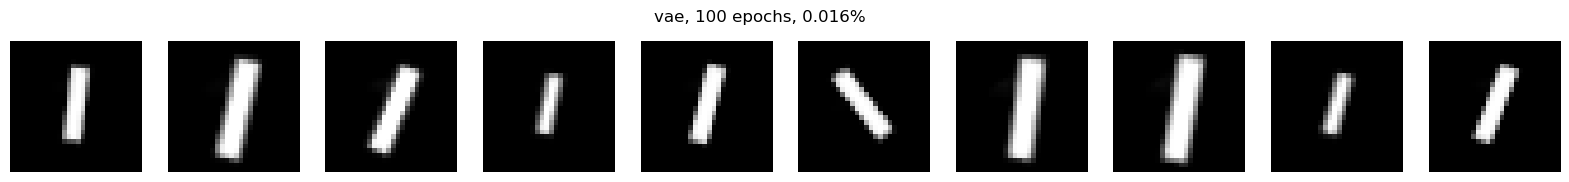

In [141]:
run_one_2(0.016, 100)

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:35<00:00,  2.85it/s]


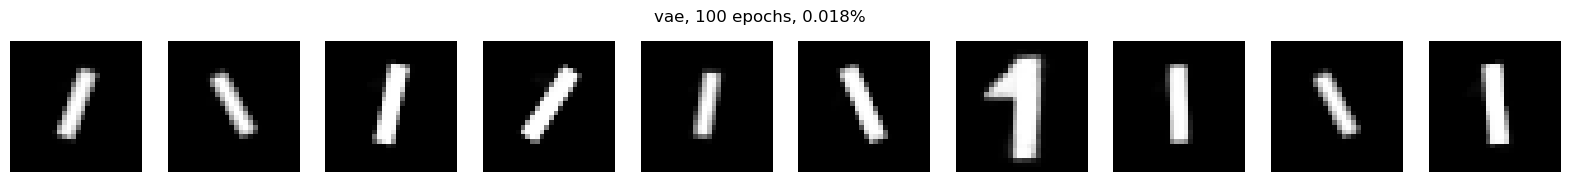

In [142]:
run_one_2(0.018, 100)

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:33<00:00,  2.99it/s]


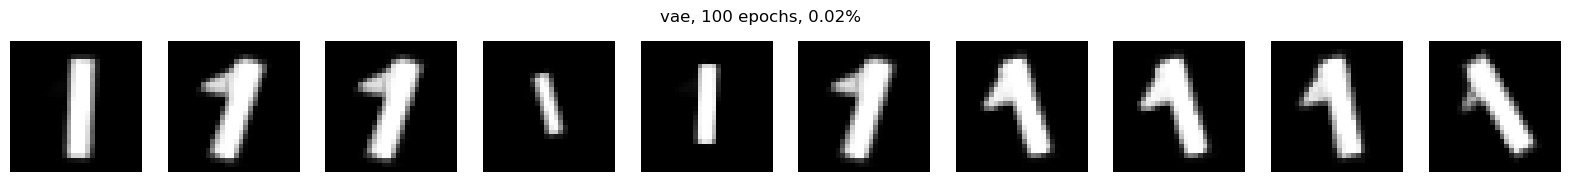

In [143]:
run_one_2(0.02, 100)

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:36<00:00,  2.76it/s]


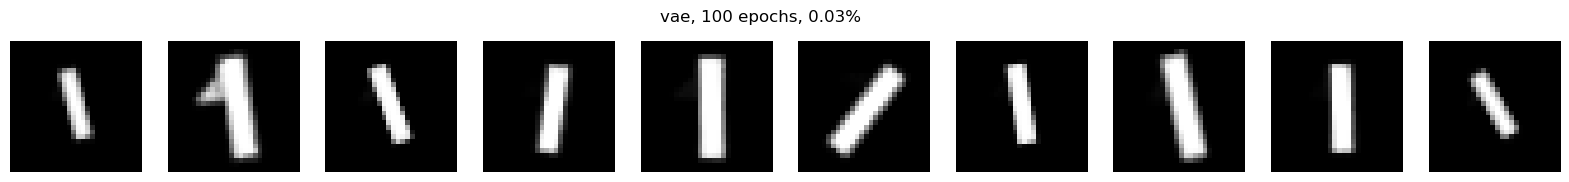

In [144]:
run_one_2(0.03, 100)

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


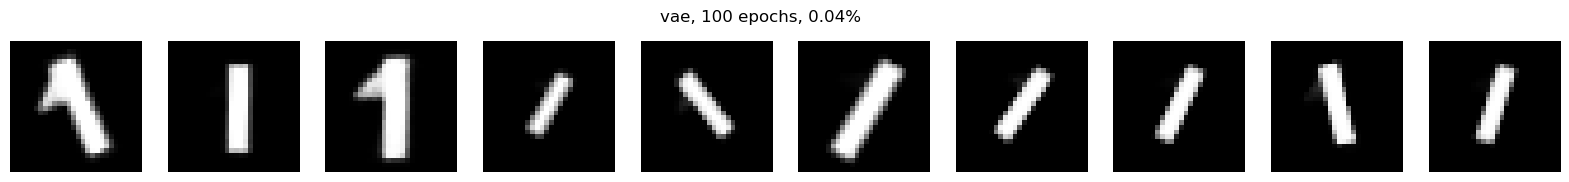

In [145]:
run_one_2(0.04, 100)

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:36<00:00,  2.77it/s]


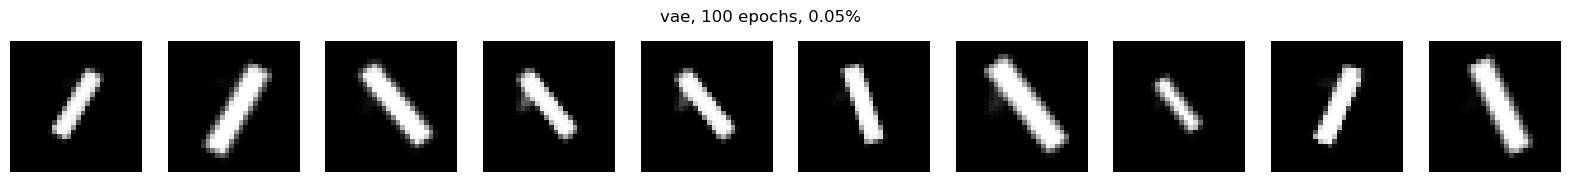

In [146]:
run_one_2(0.05, 100)

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


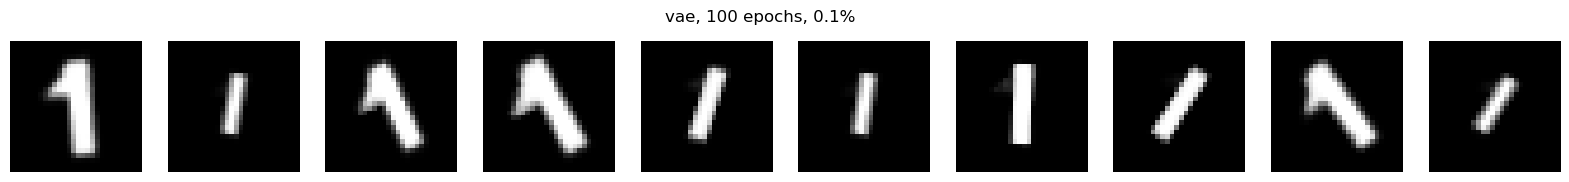

In [147]:
run_one_2(0.1, 100)

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


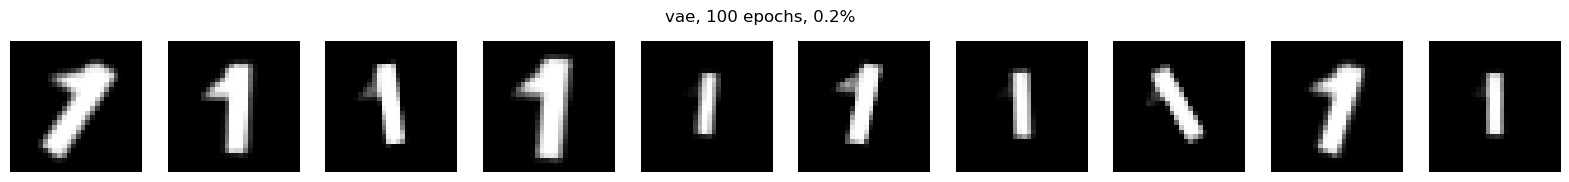

In [148]:
run_one_2(0.2, 100)

Now, it is working on cuda:0.


100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


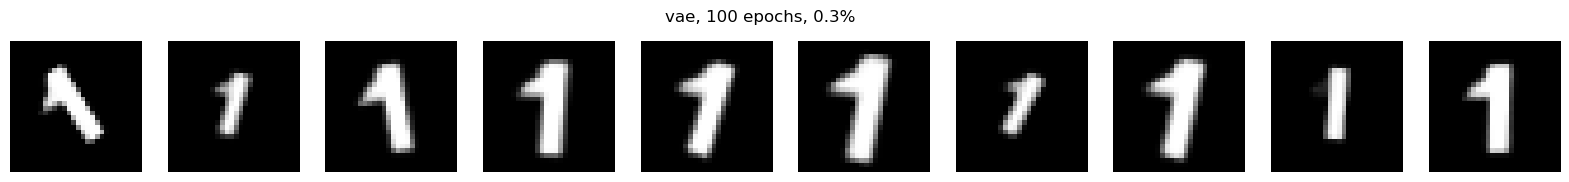

In [149]:
run_one_2(0.3, 100)